**Entendiendo el problema:**

-  Retail es un conjunto de datos transnacional que contiene todas las transacciones que 
tuvieron lugar entre el 12/01/2010 y el 12/09/2011 para un comercio minorista en línea sin 
tienda registrado y con sede en el Reino Unido.
- La empresa vende principalmente regalos 
únicos para todas las ocasiones. 
- La empresa sospecha que entre todos los clientes que le están 
comprando algunos son mayoristas, pero no tiene la seguridad de quienes lo son y quiénes no. 
- **Conocer qué clientes es mayorista es importante debido a que la empresa comenzará a usar 
una estrategia de precios diferenciada por cliente.** 

Las columnas que tenemos son:
- **InvoiceNo:** Número de factura. Nominal, número integral de 6 dígitos asignado de forma única 
a cada transacción. Si este código comienza con la letra 'c', indica una cancelación. 
- **StockCode:** Código de producto (artículo). Nominal, un número entero de 5 dígitos asignado 
de forma única a cada producto distinto. 
- **Description:** Nombre del producto (artículo). Nominal. 
- **Quantity:** Las cantidades de cada producto (artículo) por transacción. Numérico.
- **InvoiceDate:** Fecha y hora de la factura. Numérico, el día y hora en que se generó cada 
transacción. 
- **UnitPrice:** Precio unitario. Numérico, Precio del producto por unidad en libras esterlinas. 
- **CustomerID:** Número de cliente. Nominal, número integral de 5 dígitos asignado de forma 
única a cada cliente. 
- **Country:** Nombre del país. Nominal, el nombre del país donde reside cada cliente.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score

from collections import Counter
import warnings
import os

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
data_original = pd.read_excel('Online Retail.xlsx')

In [4]:
data = data_original.copy()

## 1. Preprocesamiento de datos

In [5]:
data.head(5)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [6]:
print(data.shape) # ¿Qué tan grande es la base de datos?
print(data.dtypes)

(541909, 8)
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64


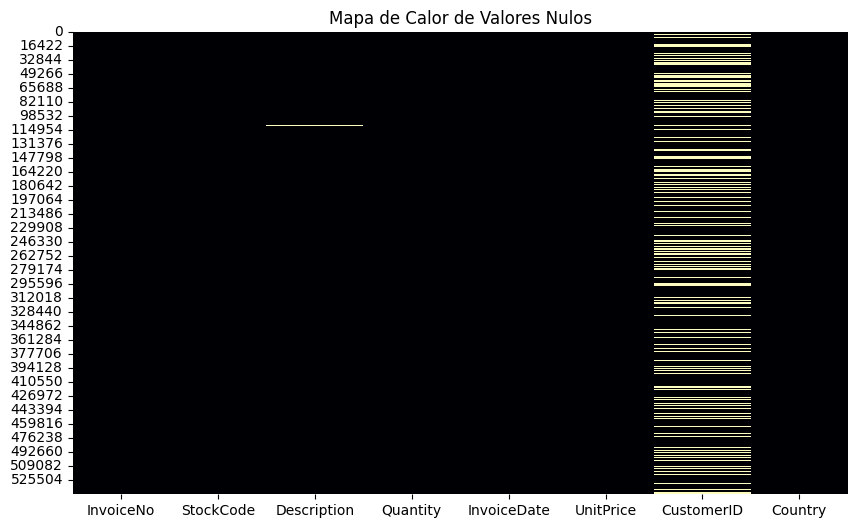

In [7]:
print(data.isnull().mean()*100) # Porcentaje de valores perdidos
# Mapa de calor de valores perdidos
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cmap='magma', cbar=False)
plt.title('Mapa de Calor de Valores Nulos'); plt.show()

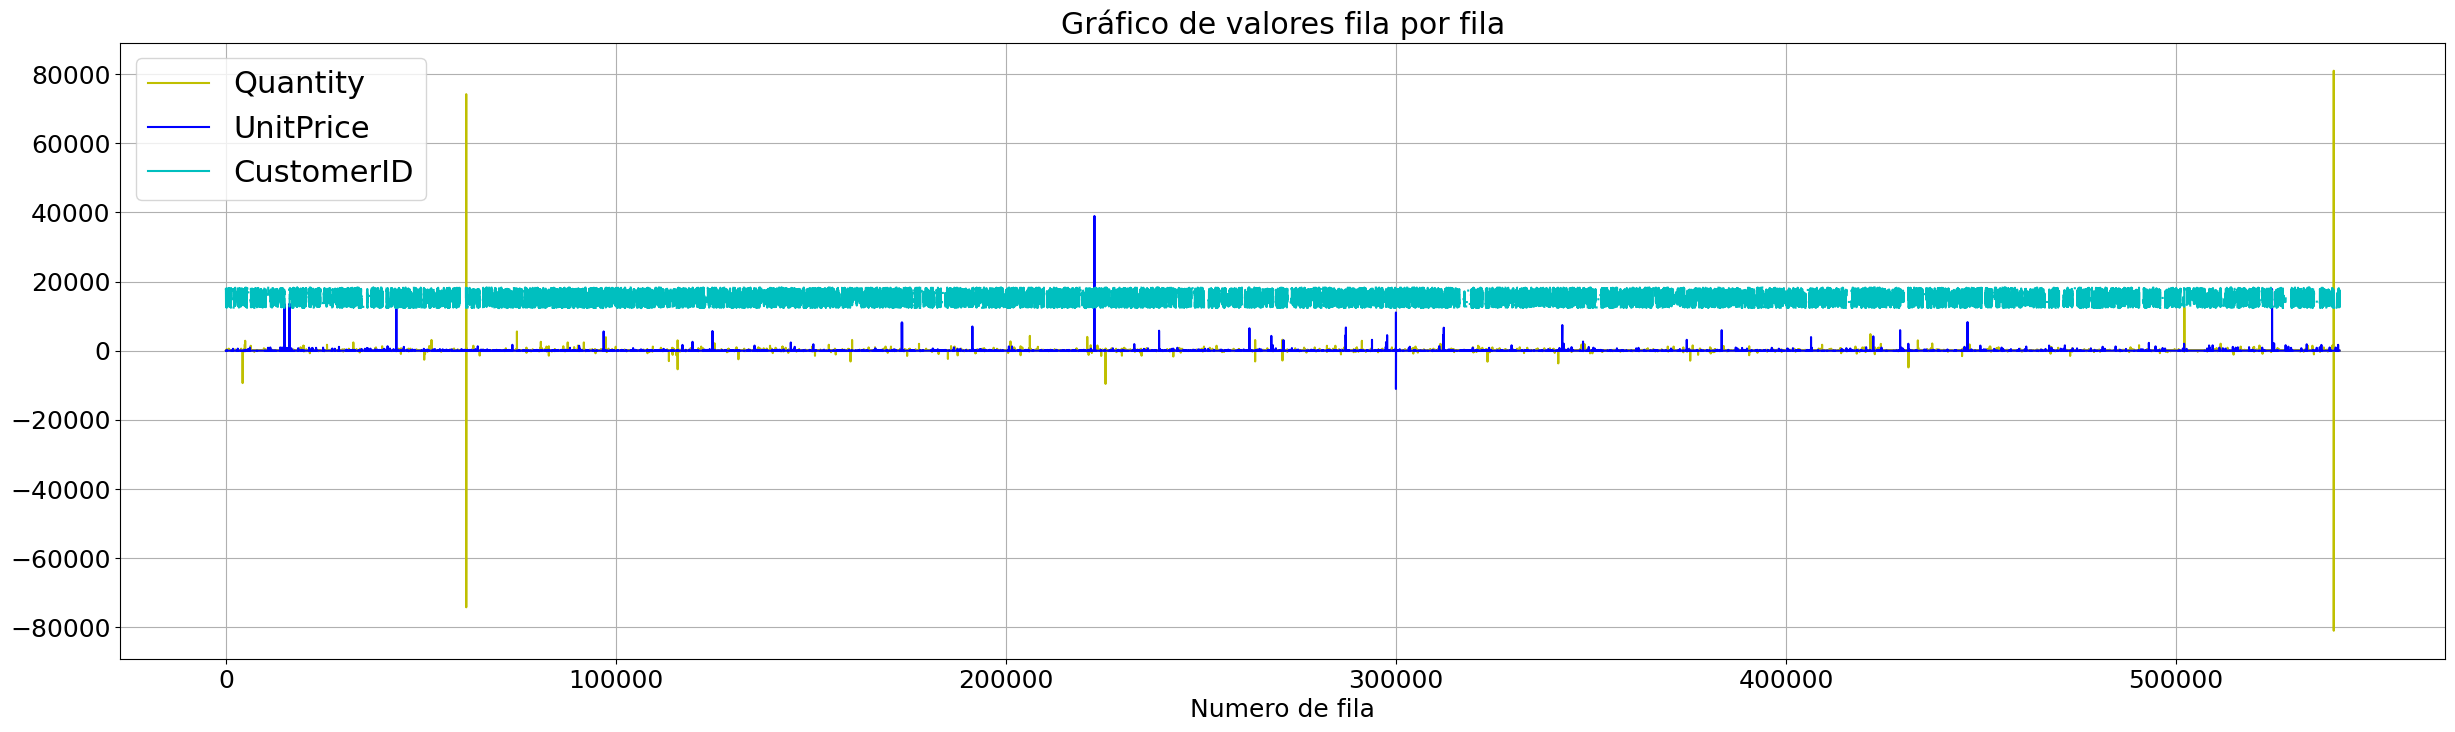

In [8]:
# Gráfico de líneas del comportamiento de los atributos numericos
with plt.rc_context({'figure.figsize': (30, 8), 'font.size': 18}):
    x = range(0, data.shape[0], 1)
    plt.plot(x, data['Quantity'], 'y-', label='Quantity')
    plt.plot(x, data['UnitPrice'], 'b-', label='UnitPrice')
    plt.plot(x, data['CustomerID'], 'c-', label='CustomerID')
    plt.title('Gráfico de valores fila por fila')
    plt.xlabel('Numero de fila'); plt.legend(prop={'size': 22}); plt.grid()
plt.show()

In [9]:
#Numero de clientes identificados:
len(data['CustomerID'].unique())

4373

In [10]:
data.describe().round(2).T

count                           mean                  min  \
Quantity     541909.0                           9.55             -80995.0   
InvoiceDate    541909  2011-07-04 13:34:57.156386048  2010-12-01 08:26:00   
UnitPrice    541909.0                           4.61            -11062.06   
CustomerID   406829.0                       15287.69              12346.0   

                             25%                  50%                  75%  \
Quantity                     1.0                  3.0                 10.0   
InvoiceDate  2011-03-28 11:34:00  2011-07-19 17:17:00  2011-10-19 11:27:00   
UnitPrice                   1.25                 2.08                 4.13   
CustomerID               13953.0              15152.0              16791.0   

                             max     std  
Quantity                 80995.0  218.08  
InvoiceDate  2011-12-09 12:50:00     NaN  
UnitPrice                38970.0   96.76  
CustomerID               18287.0  1713.6

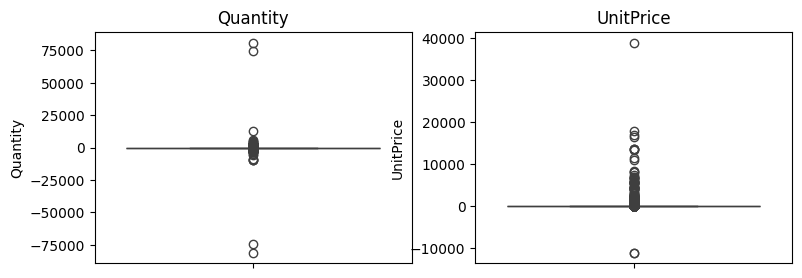

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
sns.boxplot(data['Quantity'], ax=axs[0]).set_title('Quantity')
sns.boxplot(data['UnitPrice'], ax=axs[1]).set_title('UnitPrice')
plt.show()

In [12]:
print('¿Todo valor negativo de cantidad corresponde a un codigo de factura que inicia con C?')
print(all((data['InvoiceNo'].astype(str).str.startswith('C')) & (data['Quantity'] < 0)))

print('¿Todo código de facturación que inicia con C corresponde a una cantidad negativa?')
print(all((data['InvoiceNo'].astype(str).str.startswith('C')) == (data['Quantity'] < 0)))

¿Todo valor negativo de cantidad corresponde a un codigo de factura que inicia con C?
False
¿Todo código de facturación que inicia con C corresponde a una cantidad negativa?
False


In [13]:
data[data['UnitPrice']>17000]

InvoiceNo  StockCode Description  Quantity         InvoiceDate  \
222681   C556445          M      Manual        -1 2011-06-10 15:31:00   
524602   C580605  AMAZONFEE  AMAZON FEE        -1 2011-12-05 11:36:00   

        UnitPrice  CustomerID         Country  
222681   38970.00     15098.0  United Kingdom  
524602   17836.46         NaN  United Kingdom

In [14]:
data.describe(include = 'O').round(2).T

count unique                                 top    freq
InvoiceNo    541909  25900                              573585    1114
StockCode    541909   4070                              85123A    2313
Description  540455   4223  WHITE HANGING HEART T-LIGHT HOLDER    2369
Country      541909     38                      United Kingdom  495478

In [15]:
descripciones = data['Description']
contador_descripciones = Counter(descripciones)
descripciones_mas_comunes = contador_descripciones.most_common(20)
descripciones_mas_comunes

[('WHITE HANGING HEART T-LIGHT HOLDER', 2369),
 ('REGENCY CAKESTAND 3 TIER', 2200),
 ('JUMBO BAG RED RETROSPOT', 2159),
 ('PARTY BUNTING', 1727),
 ('LUNCH BAG RED RETROSPOT', 1638),
 ('ASSORTED COLOUR BIRD ORNAMENT', 1501),
 ('SET OF 3 CAKE TINS PANTRY DESIGN ', 1473),
 (nan, 1454),
 ('PACK OF 72 RETROSPOT CAKE CASES', 1385),
 ('LUNCH BAG  BLACK SKULL.', 1350),
 ('NATURAL SLATE HEART CHALKBOARD ', 1280),
 ('POSTAGE', 1252),
 ('JUMBO BAG PINK POLKADOT', 1251),
 ('HEART OF WICKER SMALL', 1237),
 ('JAM MAKING SET WITH JARS', 1229),
 ('JUMBO STORAGE BAG SUKI', 1214),
 ("PAPER CHAIN KIT 50'S CHRISTMAS ", 1210),
 ('JUMBO SHOPPER VINTAGE RED PAISLEY', 1202),
 ('LUNCH BAG CARS BLUE', 1197),
 ('LUNCH BAG SPACEBOY DESIGN ', 1192)]

In [16]:
filtro_pack = data['Description'].str.contains('PACK', case=False, na=False)
filtro_set = data['Description'].str.contains('SET', case=False, na=False)

contador_pack = data[filtro_pack]['Description'].value_counts()
contador_set = data[filtro_set]['Description'].value_counts()

print("Frecuencia de descripciones que contienen 'PACK':")
print(contador_pack)

print("\nFrecuencia de descripciones que contienen 'SET':")
print(contador_set)

Frecuencia de descripciones que contienen 'PACK':
Description
PACK OF 72 RETROSPOT CAKE CASES        1385
PACK OF 60 PINK PAISLEY CAKE CASES      896
CLOTHES PEGS RETROSPOT PACK 24          792
PACK OF 20 NAPKINS PANTRY DESIGN        709
PACK OF 72 SKULL CAKE CASES             678
                                       ... 
DIAMANTE HAIR GRIP PACK/2 BLACK DIA      11
DIAMANTE HAIR GRIP PACK/2 MONTANA        11
PACK 20 DOLLY PEGS                        4
PACK OF 12 DOILEY TISSUES                 2
PACK 4 FLOWER/BUTTERFLY PATCHES           1
Name: count, Length: 79, dtype: int64

Frecuencia de descripciones que contienen 'SET':
Description
SET OF 3 CAKE TINS PANTRY DESIGN       1473
JAM MAKING SET WITH JARS               1229
JAM MAKING SET PRINTED                 1182
SET OF 4 PANTRY JELLY MOULDS           1111
SET/20 RED RETROSPOT PAPER NAPKINS     1015
                                       ... 
sold as set on dotcom and amazon          1
sold as set by dotcom                     1
SE

In [17]:
data[data.duplicated()==True]

InvoiceNo StockCode                        Description  Quantity  \
517       536409     21866        UNION JACK FLAG LUGGAGE TAG         1   
527       536409     22866      HAND WARMER SCOTTY DOG DESIGN         1   
537       536409     22900    SET 2 TEA TOWELS I LOVE LONDON          1   
539       536409     22111       SCOTTIE DOG HOT WATER BOTTLE         1   
555       536412     22327  ROUND SNACK BOXES SET OF 4 SKULLS         1   
...          ...       ...                                ...       ...   
541675    581538     22068        BLACK PIRATE TREASURE CHEST         1   
541689    581538     23318     BOX OF 6 MINI VINTAGE CRACKERS         1   
541692    581538     22992             REVOLVER WOODEN RULER          1   
541699    581538     22694                       WICKER STAR          1   
541701    581538     23343       JUMBO BAG VINTAGE CHRISTMAS          1   

               InvoiceDate  UnitPrice  CustomerID         Country  
517    2010-12-01 11:45:00       1.25     17908.0  United Kingdom  
527    2010-12-01 11:45:00       2.10     17908.0  United Kingdom  
537    2010-12-01 11:45:00       2.95     17908.0  United Kingdom  
539    2010-12-01 11:45:00       4.95     17908.0  United Kingdom  
555    2010-12-01 11:49:00       2.95     17920.0  United Kingdom  
...                    ...        ...         ...             ...  
541675 2011-12-09 11:34:00       0.39     14446.0  United Kingdom  
541689 2011-12-09 11:34:00       2.49     14446.0  United Kingdom  
541692 2011-12-09 11:34:00       1.95     14446.0  United Kingdom  
541699 2011-12-09 11:34:00       2.10     14446.0  United Kingdom  
541701 2011-12-09 11:34:00       2.08     14446.0  United Kingdom  

[5268 rows x 8 columns]

In [18]:
# Verificar si hay alguna fila duplicada en todo el DataFrame
hay_duplicados = data.duplicated().any()

# Imprimir el resultado
print(f"¿Existen filas duplicadas en el DataFrame? {hay_duplicados}")

¿Existen filas duplicadas en el DataFrame? True


### Conclusiones de la exploración de data:

- *La data esta conformada por 541  908  filas y 8 columnas.*
- *Se observan valores nulos en las columnas "Description" (0.26 %) y en "CustomerID" (24.92%).* 
- *Se observa posible aleatoriedad en los registros nulos, es decir no se encuentran concentrados en un sector del registro.* 
- *Se observa valores atipicos en la variable "Quantity" tambien valores negativos.*
- *Se observa que los posibles valores atipicos en la variable "Quantity" se cancelan al ser sumadas.*
- *El numero de clientes identificados en la data es de 4373.*
- *Se observa en los estadisticos descriptivos valores atipicos en Quantity y UnitPrice, tanto negativos como positivos.*
- *Se imprime las filas con UnitPrice mayores que 17 000 y encontramos que corresponden a cantidades negativas y cancelación de facturación.*
- *Encontramos dentro de la variable descripción las palabras PACK y SET, que posiblemente podrían ayudarnos con la segmentación, para propositos del objetivo.*
- *En la data existen filas duplicadas*

In [19]:
# Se encontraron datos atipicos, por ello procedemos a eliminar  las colas de distribución al 0.5%.
# La eliminación de estas dos colas es para las variables Quantity y UnitPrice, debemos ser muy cuidadosos al eliminar estos valores
# atipicos, es por ello solo consideramos el 0.05%.
columns_to_filter = ['Quantity', 'UnitPrice']
percentile_1 = data[columns_to_filter].quantile(0.005)
percentile_99 = data[columns_to_filter].quantile(0.995)

for col in columns_to_filter:
    data = data[(data[col] >= percentile_1[col]) & (data[col] <= percentile_99[col])]

In [20]:
#Borramos los registros con valores nulos que en su gran mayoria se
# encuentran en CustomerID, dado el objetivo de este trabajo, seria peligroso poder imputar esta variable.
data.dropna(inplace = True)
# tambien para obtener una tabla con nuestros clientes edentificados con su respectiva clase

In [21]:
# Eliminamos las filas duplicadas
data = data.drop_duplicates()

### Agregación de variables

*precio_total:*

Esta variable representa el costo total de cada transacción, calculado multiplicando la cantidad de productos por su precio unitario. 
Es útil para entender el gasto total de cada cliente en sus transacciones.

**consumo_total:**

La variable 'consumo_total' se crea mediante la operación de agrupación por 'CustomerID' y sumando los valores de 'precio_total'. Esto proporciona el gasto total de cada cliente en todas sus transacciones. El consumo total es una métrica clave para entender la contribución financiera de cada cliente al negocio. Puede ser útil para identificar a los clientes más valiosos y diseñar estrategias de retención o incentivos.

In [22]:
data['precio_total'] = data['Quantity']*data['UnitPrice']

In [23]:
# Agrupar por 'CustomerID' y calcular el consumo total
precio_sum = data.groupby('CustomerID')['precio_total'].sum().reset_index(name='consumo_total')

**ultimo_dia:**

La variable 'ultimo_dia' se crea restando la fecha y hora de cada transacción del día y hora máximos en el conjunto de datos. Esta variable proporciona la antigüedad de la última transacción de cada cliente. Puede ayudar a entender cuánto tiempo ha pasado desde la última compra de cada cliente.

In [24]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'],format='%d-%m-%Y %H:%M')
max_date = max(data['InvoiceDate'])
data['ultimo_dia'] = max_date - data['InvoiceDate']

In [25]:
ultimo_dia = data.groupby('CustomerID')['ultimo_dia'].min()
ultimo_dia = ultimo_dia.reset_index()
ultimo_dia['ultimo_dia'] = ultimo_dia['ultimo_dia'].dt.days

**set_pack:**

La variable 'set_pack' se crea mediante la operación de agrupación por 'CustomerID' y sumando los valores de 'Set_Pack'. Esto indica la cantidad total de veces que un cliente ha comprado productos que contienen las palabras 'SET' o 'PACK' en su descripción. Puede ser útil para identificar patrones de compra específicos, como la preferencia por conjuntos o paquetes de productos.


In [26]:
data['Set_Pack'] = data['Description'].str.contains('SET|PACK', case=False, na=False)

In [27]:
# Agrupa por CustomerID y suma el Set_Pack
set_pack = data.groupby('CustomerID')['Set_Pack'].sum().reset_index(name='set_pack')

**country:**
La variable 'country' se crea mediante la operación de agrupación por 'CustomerID' y se calcula la moda del país para cada cliente. La moda es el valor que aparece con mayor frecuencia. Al obtener el país más común para cada cliente, se proporciona una indicación de la ubicación geográfica principal de los clientes. Esto puede ser útil para entender la distribución geográfica de la base de clientes y personalizar estrategias de marketing o servicios según la región.

In [28]:
# Agrupar por 'CustomerID' y calcular la moda de 'Country'
country_mode = data.groupby('CustomerID')['Country'].agg(lambda x: x.mode().iat[0] if not x.mode().empty else None).reset_index(name='country')


**frecuencia:**

La variable 'frecuencia' se crea mediante la operación de agrupación por 'CustomerID' y contando los valores únicos de 'InvoiceNo'. Esto indica la cantidad total de facturas únicas generadas por cada cliente. La frecuencia de compras puede ser un indicador clave del nivel de actividad de un cliente en términos de realizar transacciones. Un cliente con una frecuencia alta puede considerarse como un cliente activo que realiza compras con regularidad.


In [29]:
# Agrupar por 'CustomerID' y contar los valores únicos de 'InvoiceNo'
invoice_count = data.groupby('CustomerID')['InvoiceNo'].nunique().reset_index(name='frecuencia')

**variedad_producto:**

La variable 'variedad_producto' se crea mediante la operación de agrupación por 'CustomerID' y contando los valores únicos de 'StockCode'. Esto indica la variedad de productos distintos comprados por cada cliente. La variedad de productos puede ser un indicador importante de la diversificación de las preferencias de compra de un cliente. Un cliente que compra una variedad más amplia de productos puede ser catalogado como mayorista.


In [30]:
# Agrupar por 'CustomerID' y contar los valores únicos de 'StockCode'
stock_count = data.groupby('CustomerID')['StockCode'].nunique().reset_index(name='variedad_producto')

**purchasecount:**

La variable 'purchasecount' se crea mediante la operación de agrupación por 'CustomerID' y contando el tamaño del grupo de 'InvoiceDate'. Esto proporciona la cantidad total de compras realizadas por cada cliente. Contar la cantidad de compras puede ser útil para entender la actividad de compra a lo largo del tiempo y segmentar a los clientes en función de su nivel de participación.


In [31]:
# Agrupa por CustomerID y cuenta la cantidad de compras por fecha
count_fecha = data.groupby('CustomerID')['InvoiceDate'].size().reset_index(name='purchasecount')

- - - - - - - - 

**Combinar los resultados en un solo DataFrame:**


In [32]:
df = ultimo_dia.merge(count_fecha, on='CustomerID').merge(precio_sum, on='CustomerID').merge(country_mode, on='CustomerID').merge(invoice_count, on='CustomerID').merge(stock_count, on='CustomerID').merge(set_pack, on='CustomerID')
df

CustomerID  ultimo_dia  purchasecount  consumo_total         country  \
0        12347.0           1            181        4060.40         Iceland   
1        12348.0          74             27        1437.24         Finland   
2        12349.0          18             71        1417.60           Italy   
3        12350.0         309             16         294.40          Norway   
4        12352.0          35             80        1335.49          Norway   
...          ...         ...            ...            ...             ...   
4318     18280.0         277             10         180.60  United Kingdom   
4319     18281.0         180              7          80.82  United Kingdom   
4320     18282.0           7             13         176.60  United Kingdom   
4321     18283.0           3            721        2045.53  United Kingdom   
4322     18287.0          42             70        1837.28  United Kingdom   

      frecuencia  variedad_producto  set_pack  
0              7                102        34  
1              4                 21        14  
2              1                 71        16  
3              1                 16         0  
4              8                 57        16  
...          ...                ...       ...  
4318           1                 10         1  
4319           1                  7         2  
4320           3                 12         1  
4321          16                263       113  
4322           3                 59        18  

[4323 rows x 8 columns]

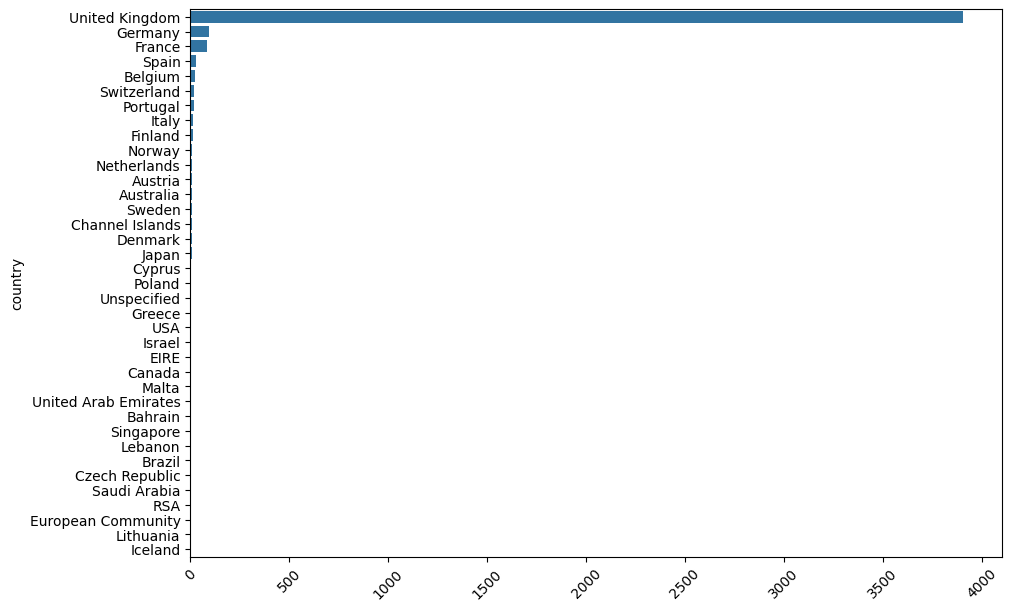

In [33]:
plt.figure(figsize =(10,6), layout = 'constrained')
counts = df['country'].value_counts()
sns.barplot(x=counts.values, y=counts.index)
plt.xticks(rotation=45); plt.show()

<Axes: xlabel='set_pack', ylabel='Count'>

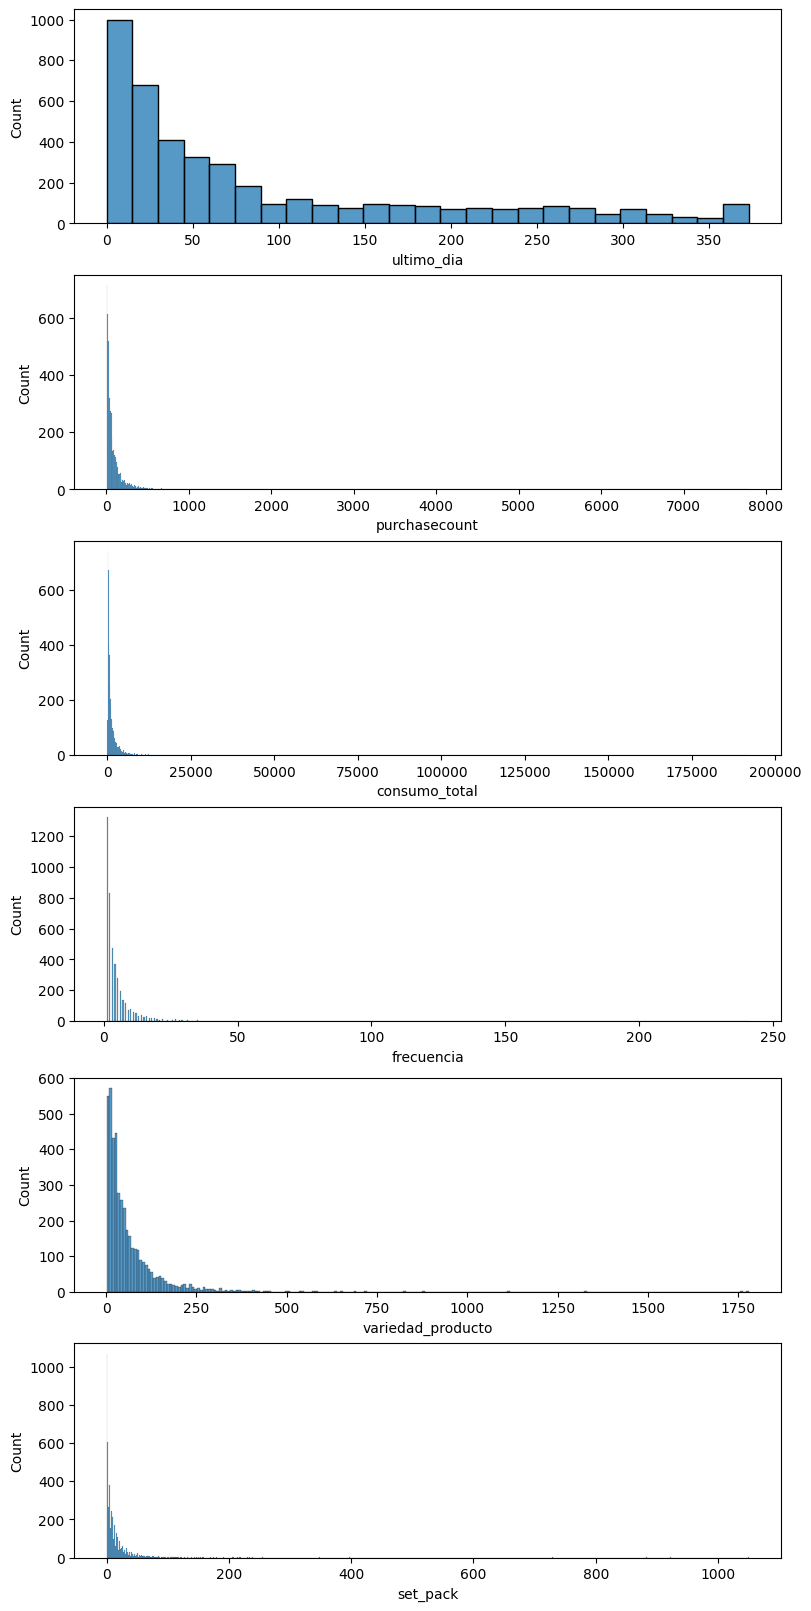

In [34]:
fig, axs = plt.subplots(6, 1, figsize=(8, 16), layout = 'constrained')

sns.histplot(df['ultimo_dia'], ax=axs[0])
sns.histplot(df['purchasecount'], ax=axs[1])
sns.histplot(df['consumo_total'], ax=axs[2])
sns.histplot(df['frecuencia'], ax=axs[3])
sns.histplot(df['variedad_producto'], ax=axs[4])
sns.histplot(df['set_pack'], ax=axs[5])


In [35]:
# Se encontraron datos atipicos en la cola derecha, por ello procedemos a el extremo al 1%.
columns_to_filter = ['purchasecount', 'consumo_total', 'frecuencia', 'variedad_producto', 'set_pack']
percentile_99 = df[columns_to_filter].quantile(0.99)

for col in columns_to_filter:
    df = df[(df[col] <= percentile_99[col])]

<Axes: xlabel='set_pack', ylabel='Count'>

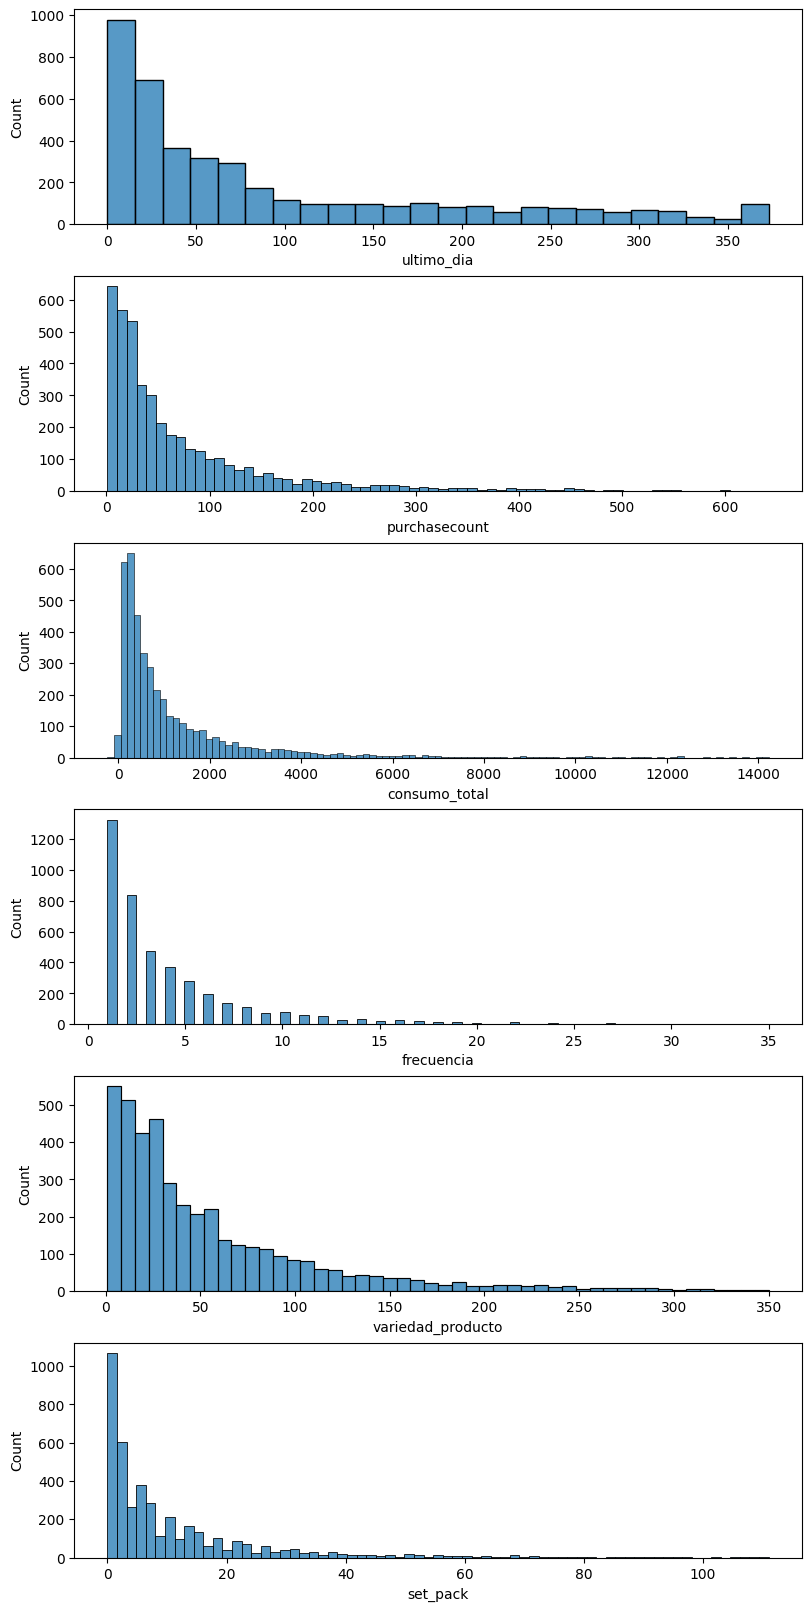

In [36]:
fig, axs = plt.subplots(6, 1, figsize=(8, 16), layout = 'constrained')

sns.histplot(df['ultimo_dia'], ax=axs[0])
sns.histplot(df['purchasecount'], ax=axs[1])
sns.histplot(df['consumo_total'], ax=axs[2])
sns.histplot(df['frecuencia'], ax=axs[3])
sns.histplot(df['variedad_producto'], ax=axs[4])
sns.histplot(df['set_pack'], ax=axs[5])

In [37]:
df.drop(columns=['country'], inplace=True) # Eliminamos esta columna debido a que se encuentra desbalanceado

In [38]:
# df.drop(columns=['CustomerID'], inplace=True)

## 2. Clusterización de los clientes.

In [39]:
columna_no_estandarizada = df['CustomerID']
df_sin_columna = df.drop(['CustomerID'], axis=1)

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_sin_columna), index=df_sin_columna.index, columns=df_sin_columna.columns)
df_scaled['CustomerID'] = columna_no_estandarizada

In [40]:
X = df_scaled.drop(['CustomerID'], axis=1)
# Determinar el número óptimo de clústeres 
inertia_values = []
silhouette_scores = []
possible_k_values_codo = range(1, 10) 
possible_k_values = range(2, 11)  
for k in possible_k_values_codo:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)
    
for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

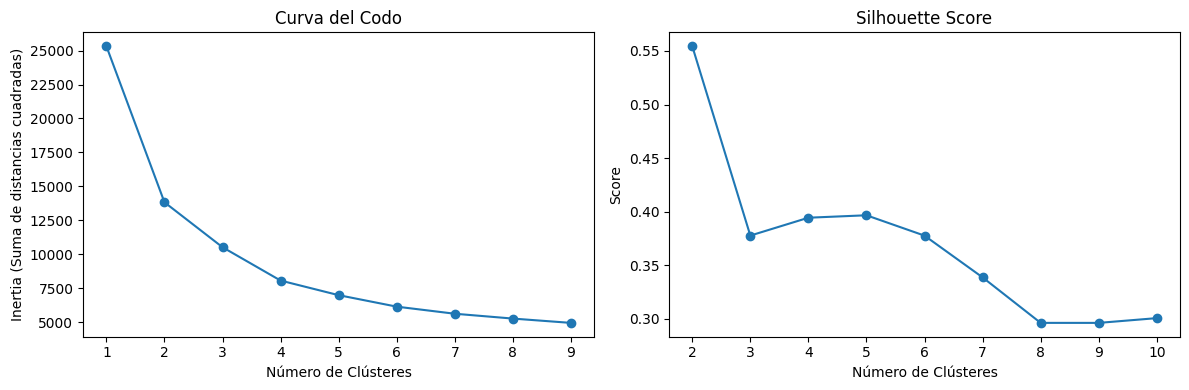

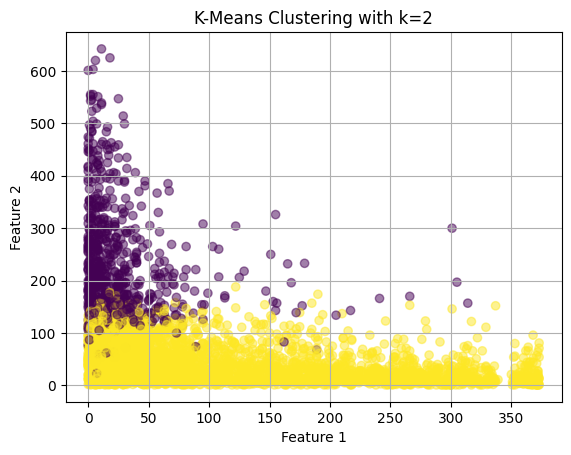

In [41]:
# Visualizar la curva del codo y el silhouette score
plt.figure(figsize=(12, 4))

# Curva del codo
plt.subplot(1, 2, 1)
plt.plot(possible_k_values_codo, inertia_values, marker='o')
plt.title('Curva del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('Inertia (Suma de distancias cuadradas)')

# Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(possible_k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Número de Clústeres')
plt.ylabel('Score')


plt.tight_layout()
plt.show(); plt.grid()

# Elegir el número de clusteres en este nos guiamos del objetivo planteado
optimal_k = 2

# Inicializar y ajustar el modelo K-Means con el número óptimo de clústeres
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
y_kmeans = kmeans.fit_predict(X)

# Añadir información de clúster al DataFrame original
df = pd.DataFrame(df, columns=df_scaled.columns)
df['Cluster'] = y_kmeans


# Visualizar los clústeres
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.5)
plt.title(f"K-Means Clustering with k={optimal_k}")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [42]:
labels = kmeans.labels_
print(labels)
counts = np.bincount(labels[labels>=0])
print(counts)

size_clusters = pd.DataFrame(counts, columns = ['size'])
print(size_clusters)

[0 1 1 ... 1 1 1]
[ 727 3494]
   size
0   727
1  3494


In [43]:
centers = kmeans.cluster_centers_
centers = pd.DataFrame(centers, columns = df_scaled.drop(['CustomerID'], axis=1).columns)
print(centers)

centersde = scaler.inverse_transform(centers)
data_centers = pd.DataFrame(centersde, columns = df_scaled.drop(['CustomerID'], axis=1).columns)
data_centers['ID'] = np.arange(len(data_centers))
print(data_centers)

   ultimo_dia  purchasecount  consumo_total  frecuencia  variedad_producto  \
0   -0.666749       1.732473       1.487122    1.483017           1.661305   
1    0.138731      -0.360477      -0.309427   -0.308573          -0.345669   

   set_pack  
0  1.574588  
1 -0.327626  
   ultimo_dia  purchasecount  consumo_total  frecuencia  variedad_producto  \
0   25.558459     227.625860    3686.887538   10.740028         150.303989   
1  106.663709      40.752147     696.070215    2.713223          34.829422   

    set_pack  ID  
0  34.635488   0  
1   6.022324   1  


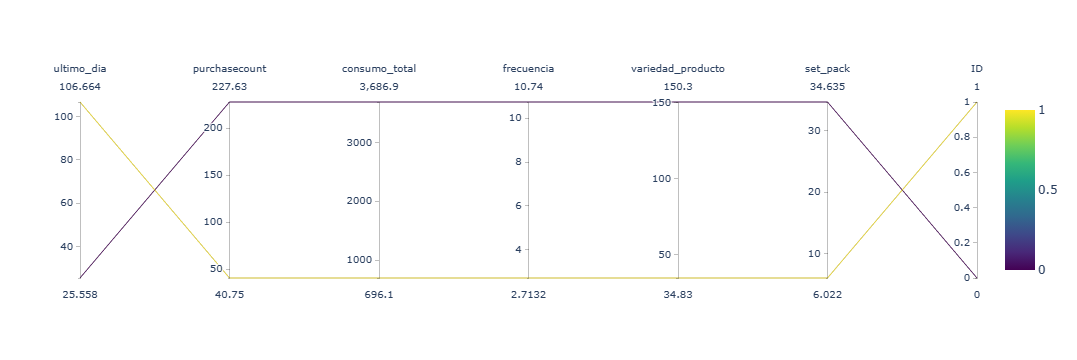

In [44]:
import plotly.graph_objects as go
#Grafico de centroides
fig = go.Figure(data=go.Parcoords(
    line=dict(color=data_centers['ID'], colorscale='Viridis', showscale=True),
    dimensions=[dict(label=col, values=data_centers[col]) for col in data_centers.columns]
))

fig.show()

#### Conclusiones clustering

**Cluster 0:**

- 727 clientes identificados en el cluster cero.
- Último Día : El tiempo promedio desde la última transacción es relativamente corto, alrededor de 25.56 dias.
- Purchase Count: Un promedio alto de compras, con alrededor de 227.63 transacciones por cliente.
- Consumo Total: El gasto total promedio es significativo, con un valor cercano a 3686.89 unidades monetarias.
- Frecuencia: Una frecuencia promedio considerable, indicando clientes que realizan compras con regularidad.
- Variedad de Producto: Una amplia variedad de productos comprados en promedio, con aproximadamente 150.30 productos distintos.
- Set Pack: Un número moderado de compras que incluyen "Set" o "Pack" de productos.
- 
**Cluster 1:**

- 3494 clientes identificados en el cluster uno.
- Último Día: El tiempo promedio desde la última transacción es más largo en comparación con el Cluster 0, con aproximadamente 106.66 dias.
- Purchase Count: Menos transacciones en promedio, con alrededor de 40.75 compras por cliente.
- Consumo Total: El gasto total promedio es más bajo en comparación con el Cluster 0, con un valor cercano a 696.07 unidades monetarias.
- Frecuencia: Una frecuencia promedio más baja en comparación con el Cluster 0, indicando clientes menos activos.
- Variedad de Producto: Una menor variedad promedio de productos comprados, con aproximadamente 34.83 productos distintos.
- Set Pack: Menos compras que incluyen "Set" o "Pack" de productos en comparación con el Cluster 0.
- 
**Conclusión:**

*Cluster 0: Mayoristas*

- El Cluster 0 emerge como la categoría que representa a los mayoristas. Estos clientes son altamente activos, realizan compras con frecuencia y tienen un gasto total significativo. Además, su diversidad en la selección de productos sugiere que están adquiriendo una amplia variedad de productos, lo cual es característico del comportamiento de los mayoristas. Estos clientes son extremadamente valiosos para el negocio, ya que contribuyen de manera sustancial al volumen de ventas y son una fuente esencial de ingresos.

*Cluster 1: Minoristas*

- El Cluster 1, por otro lado, se asocia con clientes minoristas. Aunque son menos activos en términos de frecuencia de compra y su gasto total es más moderado en comparación con los mayoristas, estos clientes representan una parte importante del mercado. Estrategias de retención y fidelización pueden ser beneficiosas para fortalecer la relación con estos clientes, incentivándolos a aumentar su frecuencia de compra y contribuir de manera más significativa al crecimiento del negocio.

*Perspectivas de la Estrategia Comercial*

- Para los mayoristas, se pueden desarrollar estrategias para optimizar la gestión de inventario, ofrecer descuentos por volumen y proporcionar un servicio al cliente personalizado.
- Para los minoristas, las estrategias podrían centrarse en programas de fidelización, promociones especiales y una atención más personalizada para impulsar la frecuencia de compra.

#### Resultado data frame incluido los grupos por cliente

In [45]:
#Resultado Final de clustering el data frame clusterizado
df

ultimo_dia  purchasecount  consumo_total  frecuencia  variedad_producto  \
0              1            181        4060.40           7                102   
1             74             27        1437.24           4                 21   
2             18             71        1417.60           1                 71   
3            309             16         294.40           1                 16   
4             35             80        1335.49           8                 57   
...          ...            ...            ...         ...                ...   
4317          73              9         173.90           1                  9   
4318         277             10         180.60           1                 10   
4319         180              7          80.82           1                  7   
4320           7             13         176.60           3                 12   
4322          42             70        1837.28           3                 59   

      set_pack  CustomerID  Cluster  
0           34     12347.0        0  
1           14     12348.0        1  
2           16     12349.0        1  
3            0     12350.0        1  
4           16     12352.0        1  
...        ...         ...      ...  
4317         1     18278.0        1  
4318         1     18280.0        1  
4319         2     18281.0        1  
4320         1     18282.0        1  
4322        18     18287.0        1  

[4221 rows x 8 columns]

#### Estadisticos descriptivos

In [46]:
df.describe().round(2).T

count      mean      std       min       25%       50%  \
ultimo_dia         4221.0     92.69   100.70      0.00     17.00     50.00   
purchasecount      4221.0     72.94    89.30      1.00     17.00     40.00   
consumo_total      4221.0   1211.19  1664.95   -234.79    280.09    612.01   
frecuencia         4221.0      4.10     4.48      1.00      1.00      2.00   
variedad_producto  4221.0     54.72    57.54      1.00     15.00     34.00   
set_pack           4221.0     10.95    15.04      0.00      1.00      5.00   
CustomerID         4221.0  15295.05  1719.55  12347.00  13814.00  15296.00   
Cluster            4221.0      0.83     0.38      0.00      1.00      1.00   

                        75%       max  
ultimo_dia           147.00    373.00  
purchasecount         94.00    642.00  
consumo_total       1440.06  14223.95  
frecuencia             5.00     35.00  
variedad_producto     74.00    350.00  
set_pack              14.00    111.00  
CustomerID         16771.00  18287.00  
Cluster                1.00      1.00

<Axes: xlabel='set_pack', ylabel='Count'>

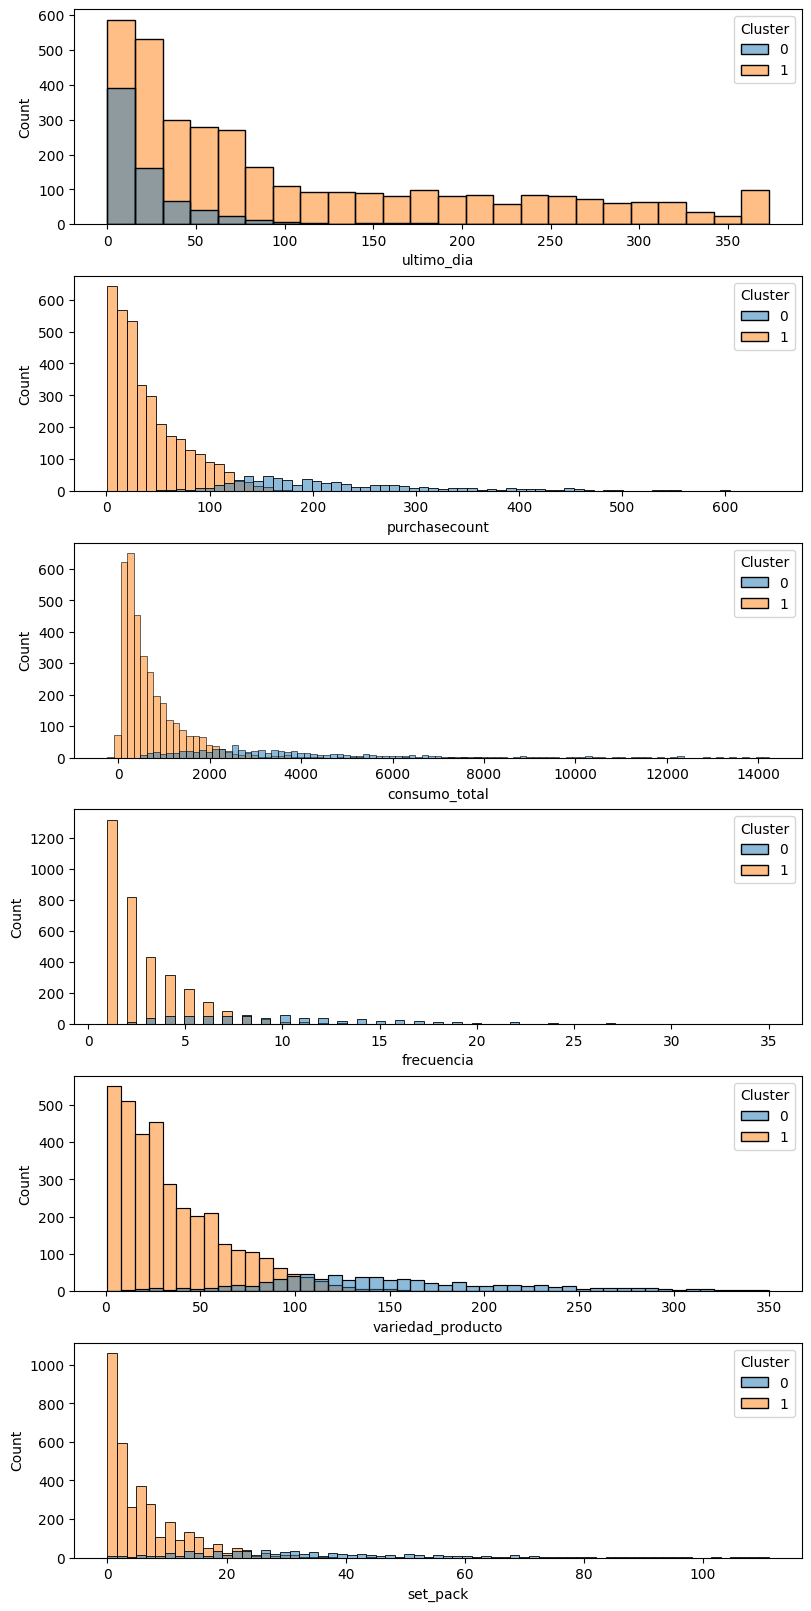

In [47]:
fig, axs = plt.subplots(6, 1, figsize=(8, 16), layout = 'constrained')

sns.histplot(data = df, x = 'ultimo_dia', hue = 'Cluster', ax=axs[0])
sns.histplot(data = df, x = 'purchasecount', hue = 'Cluster', ax=axs[1])
sns.histplot(data = df, x = 'consumo_total', hue = 'Cluster', ax=axs[2])
sns.histplot(data = df, x = 'frecuencia', hue = 'Cluster', ax=axs[3])
sns.histplot(data = df, x = 'variedad_producto', hue = 'Cluster', ax=axs[4])
sns.histplot(data = df, x = 'set_pack', hue = 'Cluster', ax=axs[5])

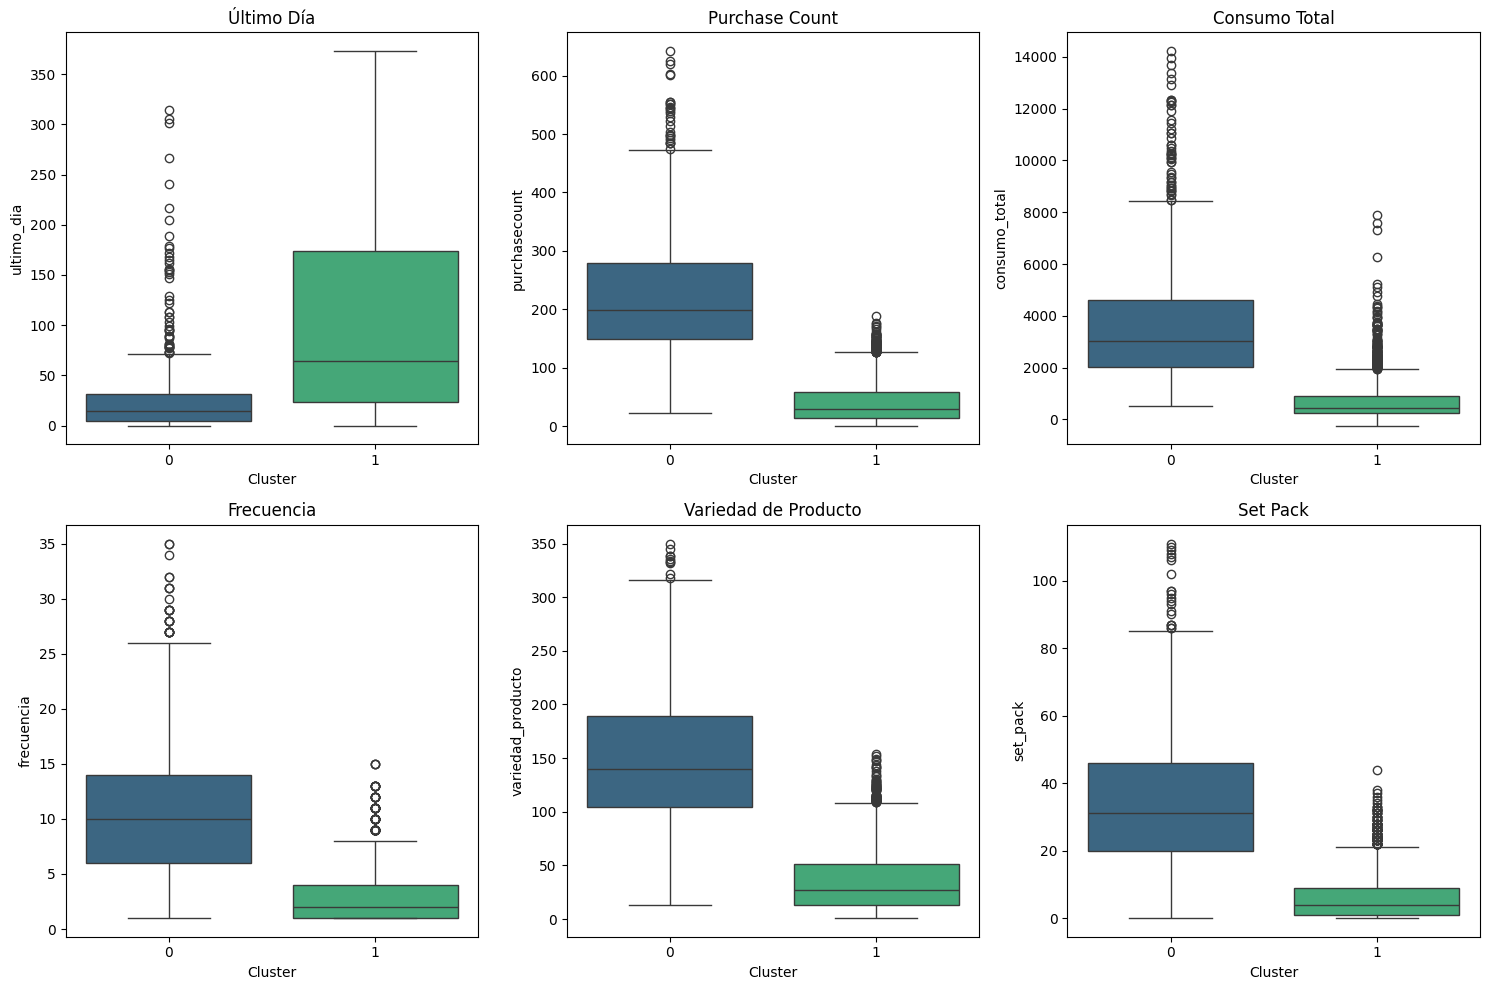

In [48]:
colores = 'viridis'
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
sns.boxplot(data=df, x='Cluster', y='ultimo_dia', ax=axs[0, 0], palette=colores)
axs[0, 0].set_title('Último Día')
sns.boxplot(data=df, x='Cluster', y='purchasecount', ax=axs[0, 1], palette=colores)
axs[0, 1].set_title('Purchase Count')
sns.boxplot(data=df, x='Cluster', y='consumo_total', ax=axs[0, 2], palette=colores)
axs[0, 2].set_title('Consumo Total')
sns.boxplot(data=df, x='Cluster', y='frecuencia', ax=axs[1, 0], palette=colores)
axs[1, 0].set_title('Frecuencia')
sns.boxplot(data=df, x='Cluster', y='variedad_producto', ax=axs[1, 1], palette=colores)
axs[1, 1].set_title('Variedad de Producto')
sns.boxplot(data=df, x='Cluster', y='set_pack', ax=axs[1, 2], palette=colores)
axs[1, 2].set_title('Set Pack')
plt.tight_layout()
plt.show()

Determinante:0.0026546999440637624


<Axes: >

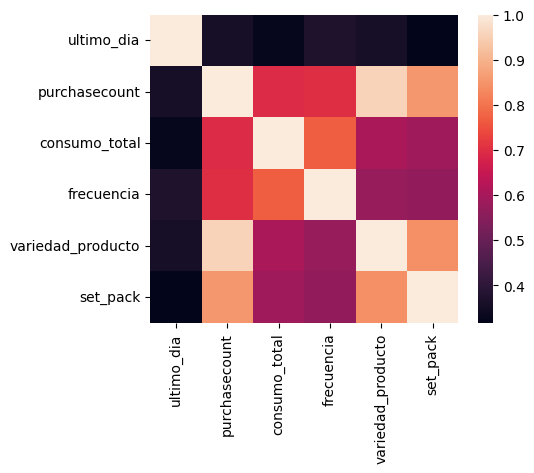

In [49]:
corrmat = pd.DataFrame(df.drop(columns = ['CustomerID', 'Cluster'])).corr().abs()
determinant = np.linalg.det(corrmat)
print(f'Determinante:{determinant}')
f, ax = plt.subplots(figsize = (5, 4))
sns.heatmap(corrmat, square = True)

## 3. Clasificación de clientes

## Entrenamiento de modelos

In [50]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.tree import export_graphviz
from imblearn.pipeline import Pipeline
from io import StringIO
from IPython.display import Image
from pydot import graph_from_dot_data

In [51]:
LABELS = ["Mayorista","Minorista"]

In [52]:
y = df['Cluster'].values
X = df_scaled.drop(['CustomerID'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state = 42)

### Regresión logística

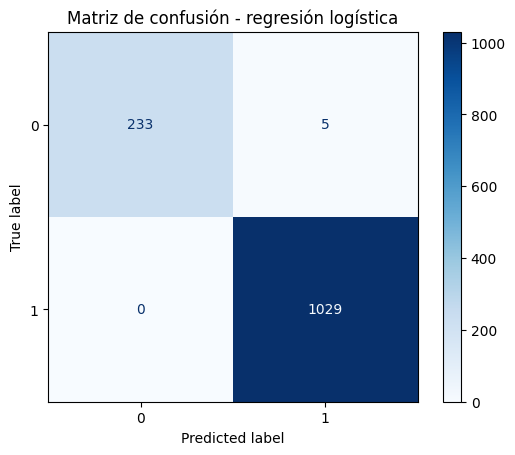

              precision    recall  f1-score   support

   Mayorista       1.00      0.98      0.99       238
   Minorista       1.00      1.00      1.00      1029

    accuracy                           1.00      1267
   macro avg       1.00      0.99      0.99      1267
weighted avg       1.00      1.00      1.00      1267



In [53]:
reg_log = LogisticRegression(random_state = 42)
reg_log.fit(X_train, y_train)
y_pred_logit = reg_log.predict(X_test)
m = metrics.confusion_matrix(y_test, y_pred_logit)

disp = ConfusionMatrixDisplay(confusion_matrix = m)
disp.plot(cmap='Blues')
plt.title('Matriz de confusión - regresión logística')
plt.show()
#Indicadores de la matriz de confusión
metricas_logit = classification_report(y_test, y_pred_logit, target_names=LABELS)
print(metricas_logit)

#Curva ROC
y_pred_proba = reg_log.predict_proba(X_test)[::,1]
fpr_logi, tpr_logi, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_logi = metrics.roc_auc_score(y_test, y_pred_proba) # Guardamos para vizualizar despues

### Arbol de decisión

In [54]:
param_dist = {'max_leaf_nodes': [5, 10, 20, 25, 30], 'max_depth': [3, 4, 5, 6, 7, 8 ]}
np.random.seed(42)
model_tree = DecisionTreeClassifier(criterion='gini')

tree_cv = RandomizedSearchCV(model_tree, param_distributions=param_dist, cv=5, n_jobs=-1)
tree_cv.fit(X_train, y_train)

print('Best params:')
print(tree_cv.best_params_)

Best params:
{'max_leaf_nodes': 20, 'max_depth': 6}


In [55]:
columns_X = ['ultimo_dia', 'PurchaseCount', 'consumo_total', 'frecuencia',
       'variedad_producto', 'set_pack']

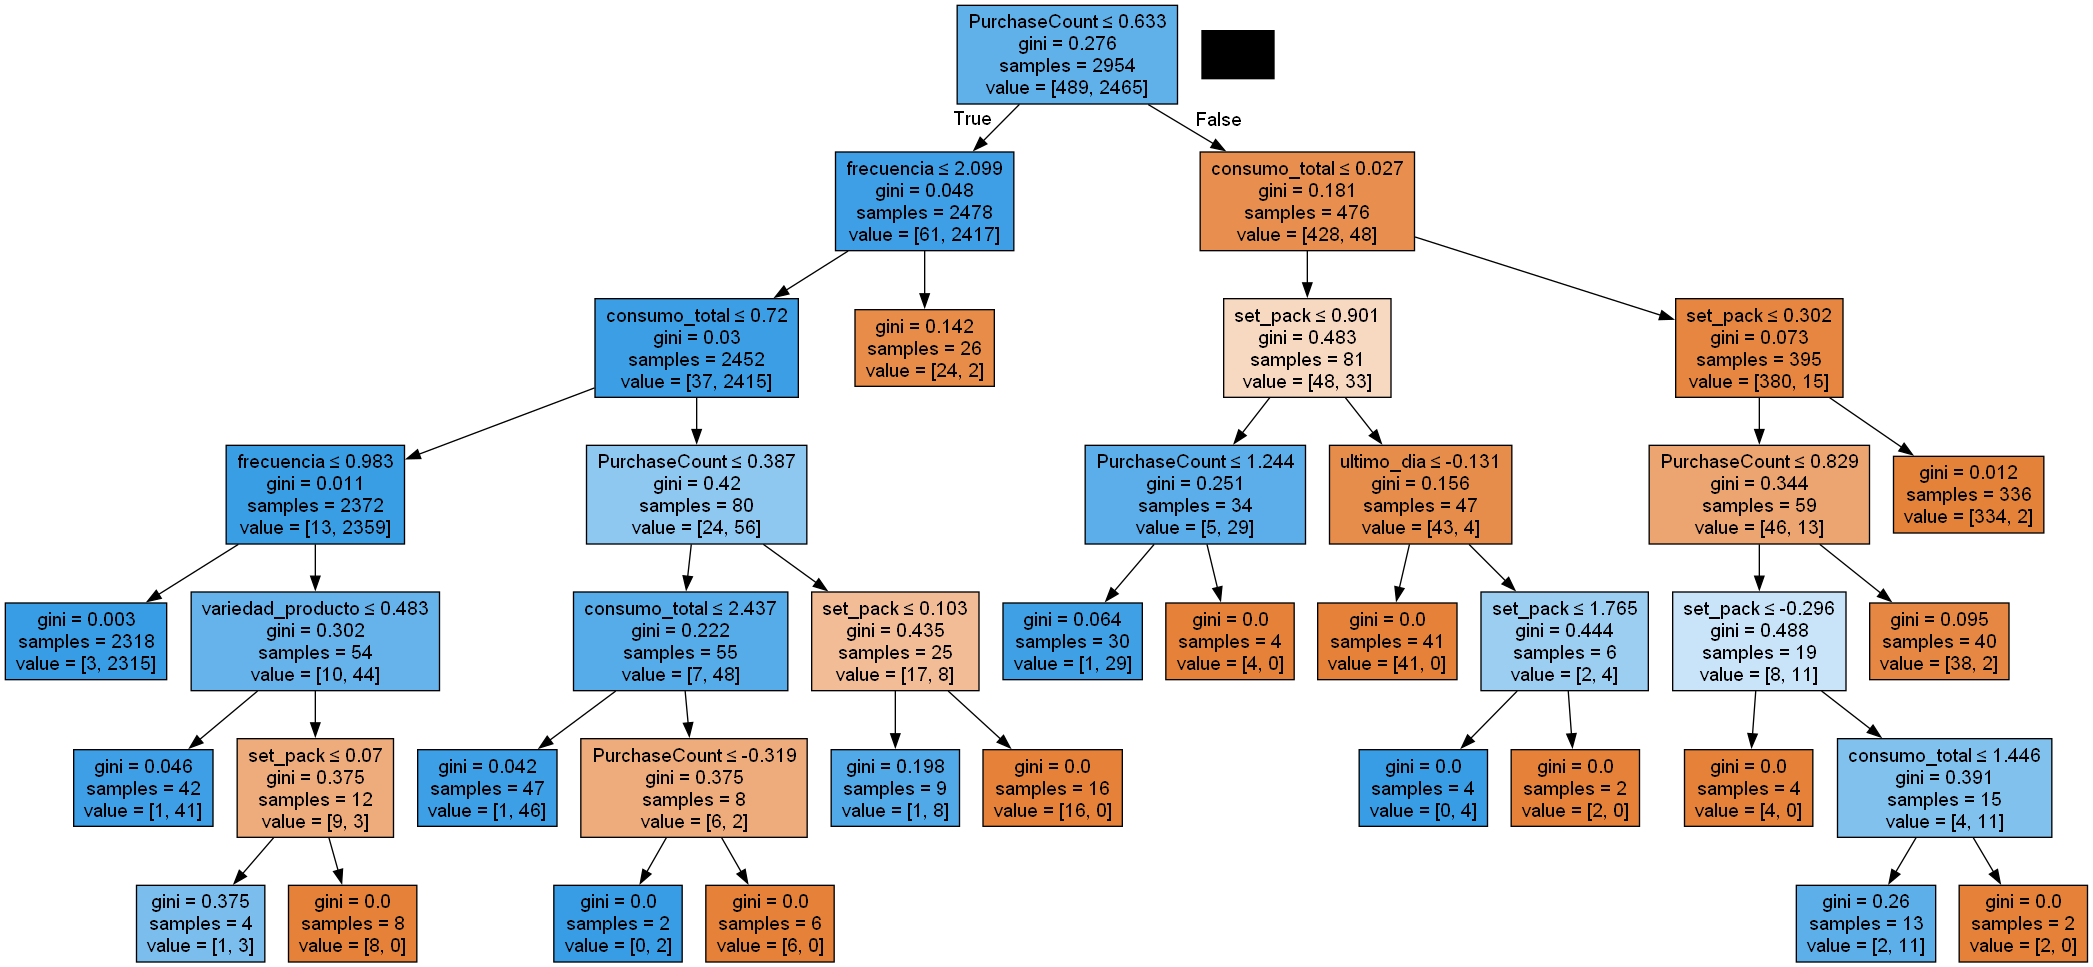

In [67]:
best_tree = tree_cv.best_estimator_
dot_data = StringIO()
export_graphviz(best_tree, out_file=dot_data, feature_names=columns_X, filled=True, special_characters=True)
(graph, ) = graph_from_dot_data(dot_data.getvalue())
graph.write_png("arbol_decision.png")
Image(graph.create_png())

              precision    recall  f1-score   support

   Mayorista       0.96      0.90      0.93       238
   Minorista       0.98      0.99      0.98      1029

    accuracy                           0.97      1267
   macro avg       0.97      0.95      0.96      1267
weighted avg       0.97      0.97      0.97      1267



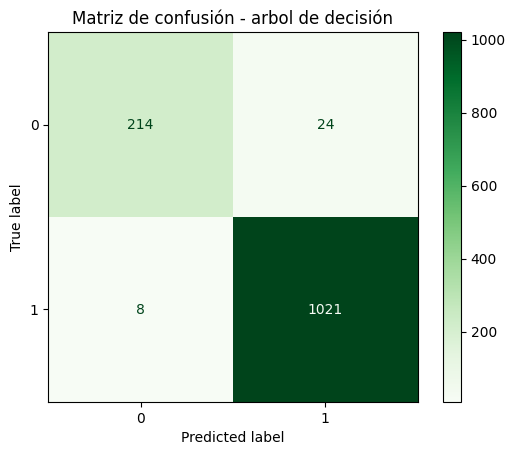

In [65]:
#matriz de confusión
y_pred_tree = best_tree.predict(X_test)
cm = confusion_matrix(y_test, y_pred_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title('Matriz de confusión - arbol de decisión')

#Indicadores de la matriz de confusión
metricas_tree = classification_report(y_test, y_pred_tree, target_names=LABELS)
print(metricas_tree)

#Curva ROC del arbol de desicion
fpr_tree, tpr_tree, _ = roc_curve(y_test, best_tree.predict_proba(X_test)[::,1])
auc_tree = roc_auc_score(y_test, y_pred_tree) # Guardamos para vizualizar despues

###  Gaussian Bayes Naives

              precision    recall  f1-score   support

   Mayorista       0.83      0.99      0.90       238
   Minorista       1.00      0.95      0.98      1029

    accuracy                           0.96      1267
   macro avg       0.92      0.97      0.94      1267
weighted avg       0.97      0.96      0.96      1267



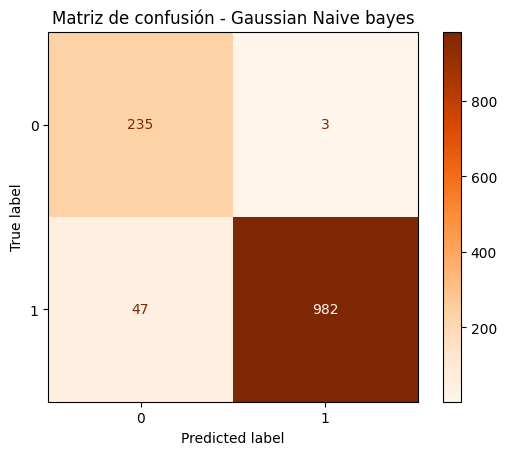

In [58]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred_gaussian = gaussian.predict(X_test)
#matriz de confusión
cm = confusion_matrix(y_test, y_pred_gaussian)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Oranges')
plt.title('Matriz de confusión - Gaussian Naive bayes')
#Indicadores de la matriz de confusión
metricas_gaussian = classification_report(y_test, y_pred_gaussian, target_names=LABELS)
print(metricas_gaussian)
#Curva ROC
y_pred_proba = gaussian.predict_proba(X_test)[::,1]
fpr_gaussian, tpr_gaussian, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_gaussian = metrics.roc_auc_score(y_test, y_pred_proba)

### KNN 

In [59]:
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
performance_metrics = []

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)
    
    y_pred = knn_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='binary')
    precision = precision_score(y_test, y_pred, average='binary')

    performance_metrics.append((k, accuracy, recall, precision))
    
    print(f"k={k}, Accuracy: {accuracy}, Recall: {recall}, Precision: {precision}")

k=1, Accuracy: 0.984214680347277, Recall: 0.9941690962099126, Precision: 0.9864995178399228
k=3, Accuracy: 0.984214680347277, Recall: 0.9951409135082604, Precision: 0.9855630413859481
k=5, Accuracy: 0.984214680347277, Recall: 0.9970845481049563, Precision: 0.9837008628954937
k=7, Accuracy: 0.9826361483820047, Recall: 0.9961127308066083, Precision: 0.9827420901246404
k=9, Accuracy: 0.9834254143646409, Recall: 0.9970845481049563, Precision: 0.9827586206896551
k=11, Accuracy: 0.984214680347277, Recall: 0.9980563654033042, Precision: 0.9827751196172249
k=13, Accuracy: 0.9826361483820047, Recall: 0.9980563654033042, Precision: 0.9808978032473734
k=15, Accuracy: 0.984214680347277, Recall: 1.0, Precision: 0.9809342230695901
k=17, Accuracy: 0.9818468823993686, Recall: 0.9990281827016521, Precision: 0.979047619047619
k=19, Accuracy: 0.9826361483820047, Recall: 1.0, Precision: 0.9790675547098002
k=21, Accuracy: 0.9834254143646409, Recall: 1.0, Precision: 0.98


              precision    recall  f1-score   support

   Mayorista       0.98      0.92      0.95       238
   Minorista       0.98      1.00      0.99      1029

    accuracy                           0.98      1267
   macro avg       0.98      0.96      0.97      1267
weighted avg       0.98      0.98      0.98      1267



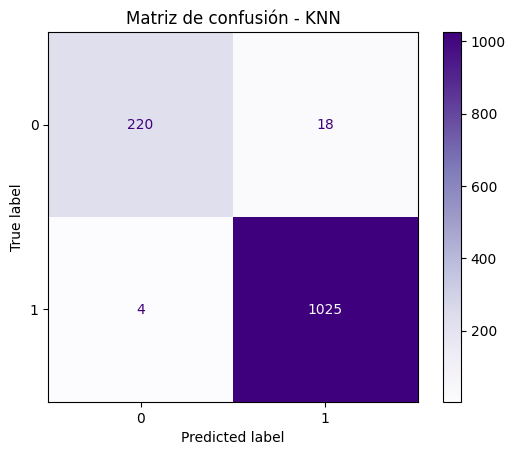

In [60]:
n_neighbors = 7

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

#matriz de confusión
cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.title('Matriz de confusión - KNN')
#Indicadores de la matriz de confusión
target_names = ['Normal', 'Fraude']
metricas_knn = classification_report(y_test, y_pred_knn, target_names=LABELS)
print(metricas_knn)
#Curva ROC
y_pred_proba = knn.predict_proba(X_test)[::,1]
fpr_knn, tpr_knn, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_knn = metrics.roc_auc_score(y_test, y_pred_proba) 

### Random Forest

In [61]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

              precision    recall  f1-score   support

   Mayorista       0.97      0.95      0.96       238
   Minorista       0.99      0.99      0.99      1029

    accuracy                           0.99      1267
   macro avg       0.98      0.97      0.98      1267
weighted avg       0.98      0.99      0.98      1267



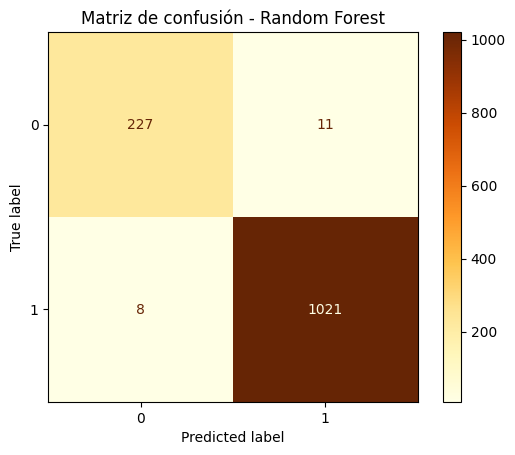

In [62]:
pipeline = make_pipeline(RandomForestClassifier(n_estimators=100, random_state=42))
pipeline.fit(X_train, y_train)

# Predicciones y evaluación
y_pred_forest = pipeline.predict(X_test)

#matriz de confusión
cm = confusion_matrix(y_test, y_pred_forest)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='YlOrBr')
plt.title('Matriz de confusión - Random Forest')
#Indicadores de la matriz de confusión
metricas_forest = classification_report(y_test, y_pred_forest, target_names=LABELS)
print(metricas_forest)
#Curva ROC
y_pred_proba = knn.predict_proba(X_test)[::,1]
fpr_forest, tpr_forest, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_forest = metrics.roc_auc_score(y_test, y_pred_proba) 

## 4. Decisión de la mejor técnica de clasificación.

## Comparación de modelos

In [63]:
# Crear un DataFrame para el cuadro comparativo
print('Logistic Regression:')
print(metricas_logit)
print('Decision Tree:')
print(metricas_tree)
print('Gaussian Naive Bayes:')
print(metricas_gaussian)
print('KNN:')
print(metricas_knn)
print('Random Forest:')
print(metricas_forest)

Logistic Regression:
              precision    recall  f1-score   support

   Mayorista       1.00      0.98      0.99       238
   Minorista       1.00      1.00      1.00      1029

    accuracy                           1.00      1267
   macro avg       1.00      0.99      0.99      1267
weighted avg       1.00      1.00      1.00      1267

Decision Tree:
              precision    recall  f1-score   support

   Mayorista       0.96      0.90      0.93       238
   Minorista       0.98      0.99      0.98      1029

    accuracy                           0.97      1267
   macro avg       0.97      0.95      0.96      1267
weighted avg       0.97      0.97      0.97      1267

Gaussian Naive Bayes:
              precision    recall  f1-score   support

   Mayorista       0.83      0.99      0.90       238
   Minorista       1.00      0.95      0.98      1029

    accuracy                           0.96      1267
   macro avg       0.92      0.97      0.94      1267
weighted avg    

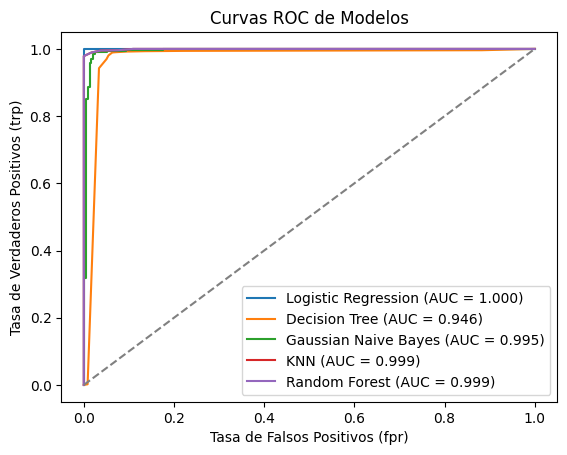

In [64]:
plt.plot(fpr_logi, tpr_logi, label=f'Logistic Regression (AUC = {auc_logi:.3f})')

plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {auc_tree:.3f})' )

plt.plot(fpr_gaussian, tpr_gaussian, label=f'Gaussian Naive Bayes (AUC = {auc_gaussian:.3f})')

plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.3f})')

plt.plot(fpr_forest, tpr_forest, label=f'Random Forest (AUC = {auc_forest:.3f})')

plt.plot([0,1], [0,1], color='gray', linestyle='--')

plt.xlabel('Tasa de Falsos Positivos (fpr)')
plt.ylabel('Tasa de Verdaderos Positivos (trp)')
plt.title('Curvas ROC de Modelos')
plt.legend(); plt.show()

vas.

Basándonos en las métricas de precisión, recall, F1-score, accuracy y el AUC de la curva ROC, parece que el modelo de Logistic Regression está presentando un rendimiento excepcionalmente bueno en la clasificación de las clases "Mayorista" y "Minorista".

- Precision y Recall perfectos: El modelo ha logrado una precisión del 100% y un recall del 98% para la clase "Mayorista", y valores del 100% tanto para precisión como recall para la clase "Minorista". Esto sugiere que el modelo tiene la capacidad de identificar correctamente la gran mayoría de instancias de ambas clases y minimizar los falsos positivos y negativos.

- F1-score alto: El F1-score, que combina precision y recall, también muestra valores cercanos al 1.0 para ambas clases, indicando un buen equilibrio entre precisión y exhaustividad.

- Accuracy del 100% y AUC de 1.0: La precisión global del modelo es del 100%, y el AUC de la curva ROC es de 1.0, lo cual es un indicador de un rendimiento perfecto en la discriminación entre las clases.

Si bien estos resultados son altamente prometedores, es importante tener en cuenta lo siguiente:

- Las métricas positivas obtenidas en los modelos de clasificación sugieren la posibilidad de que la información estructural proporcionada por K-Means haya influido de manera beneficiosa en la tarea de clasificación.

## Referencias

https://www.datacamp.com/tutorial/introduction-customer-segmentation-python

https://towardsdatascience.com/a-gentle-introduction-on-market-basket-analysis-association-rules-fa4b986a40ce